# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from loadcreon import LoadCreon
from semisuperhelper import SemiSupervisedHelper
from pnuwrapper import PNUWrapper
from jeffsearchcv import JeffRandomSearchCV
from nestedcross import NestedCV
from frankenscorer import FrankenScorer, extract_scores_from_nested, extract_score_grid
from searchrf import save_search, load_search

In [3]:
import xgboost as xgb

In [4]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.base import clone
from sklearn.metrics import f1_score, fbeta_score

In [6]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

# SET UP XGBOOST FIRST TRY! Let's do -1 and 1 outputs and linear, rmse

In [7]:
y_train_xg = y_train.copy()
y_train_xg[y_train_xg==0] = -1
y_train_xg.value_counts()

-1    350886
 1      1670
dtype: int64

In [11]:
dtrain = xgb.DMatrix(X_train.values, label=y_train_xg.values)

In [10]:
y_test_xg = y_test.copy()
y_test_xg[y_test_xg==0] = -1
y_test_xg.value_counts()

-1    87722
 1      418
dtype: int64

In [12]:
dtest = xgb.DMatrix(X_test.values, label=y_test_xg.values)

In [13]:
param = {'max_depth':6, 'eta':0.3}

In [14]:
watchlist = [(dtest,'eval'),(dtrain,'train')]

In [63]:
num_round = 15

In [64]:
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-rmse:1.05202	train-rmse:1.05179
[1]	eval-rmse:0.74236	train-rmse:0.741823
[2]	eval-rmse:0.528031	train-rmse:0.526893
[3]	eval-rmse:0.381264	train-rmse:0.379233
[4]	eval-rmse:0.28282	train-rmse:0.279565
[5]	eval-rmse:0.21879	train-rmse:0.21411
[6]	eval-rmse:0.179305	train-rmse:0.172974
[7]	eval-rmse:0.156311	train-rmse:0.148472
[8]	eval-rmse:0.143785	train-rmse:0.134576
[9]	eval-rmse:0.137182	train-rmse:0.127147
[10]	eval-rmse:0.13372	train-rmse:0.12337
[11]	eval-rmse:0.132032	train-rmse:0.120764
[12]	eval-rmse:0.131139	train-rmse:0.119739
[13]	eval-rmse:0.130807	train-rmse:0.118978
[14]	eval-rmse:0.130691	train-rmse:0.118268


In [65]:
preds = bst.predict(dtest)
labels = dtest.get_label()

In [99]:
len(preds[preds >= -0.9562]) / len(preds)

0.04911504424778761

In [100]:
y_pred = preds.copy()
y_pred[y_pred >= -0.9562] = 1
y_pred[y_pred < -0.9562] = 0

In [101]:
pd.Series(y_pred).value_counts()

0.0    83811
1.0     4329
dtype: int64

In [102]:
import creonmetrics as cm

In [103]:
cm.pr_one_unlabeled(y_test.values, y_pred)

0.045322088518632793

In [104]:
cm.pu_score(y_test.values, y_pred)

12.921750875666765

In [105]:
cm.assumed_metric(y_test.values, y_pred, fbeta_score, beta=10)

0.72910750287237958

In [90]:
cm.labeled_metric(y_test.values, y_pred, f1_score)

0.860759493670886

In [107]:
def calc_threshold(y_true, y_calced, thresholds):
    scores = []
    for t in thresholds:
        y_pred = y_calced.copy()
        y_pred[y_pred >= t] = 1
        y_pred[y_pred < t] = 0
        s = cm.assumed_metric(y_test.values, y_pred, fbeta_score, beta=10)
        scores.append(s)
    return list(zip(thresholds, scores))

In [108]:
calc_threshold(y_test, preds, np.linspace(start=-.959, stop=-0.950, num=30))

[(-0.95899999999999996, 0.72738872788615416),
 (-0.95868965517241378, 0.72748312856895647),
 (-0.9583793103448276, 0.72764051750248793),
 (-0.9580689655172413, 0.72793974417245633),
 (-0.95775862068965512, 0.72857050018413005),
 (-0.95744827586206893, 0.72864942155206025),
 (-0.95713793103448275, 0.72877573131094253),
 (-0.95682758620689656, 0.72896527807880707),
 (-0.95651724137931027, 0.72902848224736627),
 (-0.95620689655172408, 0.72910750287237958),
 (-0.9558965517241379, 0.72731216380357455),
 (-0.95558620689655172, 0.71972017641052388),
 (-0.95527586206896553, 0.7178534167970787),
 (-0.95496551724137924, 0.71790022823606137),
 (-0.95465517241379305, 0.71813437703848659),
 (-0.95434482758620687, 0.71827493964898548),
 (-0.95403448275862068, 0.71846244208053245),
 (-0.95372413793103439, 0.71877516376852602),
 (-0.9534137931034482, 0.71677986764193669),
 (-0.95310344827586202, 0.71682668234167157),
 (-0.95279310344827584, 0.71698277551553691),
 (-0.95248275862068965, 0.7171701770817

In [98]:
calc_threshold(y_test, preds, [-0.9562])

[(-0.9562, 85.83250116290472)]

# May want to try probability below using binary:logistic

In [114]:
param_bin = {'max_depth':6, 'eta':0.3, 'objective':'binary:logistic'}

In [110]:
y_train_xg_bin = y_train.copy()
y_train_xg_bin[y_train_xg==-1] = 0
y_train_xg_bin.value_counts()

0    350886
1      1670
dtype: int64

In [112]:
y_test_xg_bin = y_test.copy()
y_test_xg_bin[y_test_xg_bin==-1] = 0
y_test_xg_bin.value_counts()

0    87722
1      418
dtype: int64

In [113]:
dtrain_bin = xgb.DMatrix(X_train.values, label=y_train_xg_bin.values)
dtest_bin = xgb.DMatrix(X_test.values, label=y_test_xg_bin.values)
watchlist_bin = [(dtest_bin,'eval'),(dtrain_bin,'train')]
num_round_bin = 10

In [115]:
bst_bin = xgb.train(param_bin, dtrain_bin, num_round_bin, watchlist_bin)

[0]	eval-error:0.004879	train-error:0.004524
[1]	eval-error:0.004776	train-error:0.004527
[2]	eval-error:0.004788	train-error:0.00451
[3]	eval-error:0.004776	train-error:0.004547
[4]	eval-error:0.004731	train-error:0.004484
[5]	eval-error:0.004708	train-error:0.004462
[6]	eval-error:0.00472	train-error:0.004456
[7]	eval-error:0.004708	train-error:0.004413
[8]	eval-error:0.004742	train-error:0.004385
[9]	eval-error:0.004708	train-error:0.004354
[10]	eval-error:0.004708	train-error:0.004343
[11]	eval-error:0.004708	train-error:0.004328
[12]	eval-error:0.004708	train-error:0.004294
[13]	eval-error:0.004708	train-error:0.004292
[14]	eval-error:0.004742	train-error:0.004263
[15]	eval-error:0.004754	train-error:0.004212
[16]	eval-error:0.004742	train-error:0.00415
[17]	eval-error:0.004776	train-error:0.004099
[18]	eval-error:0.004788	train-error:0.00405
[19]	eval-error:0.004765	train-error:0.003997
[20]	eval-error:0.004754	train-error:0.00398
[21]	eval-error:0.004754	train-error:0.003934
[22

In [116]:
preds_bin = bst_bin.predict(dtest_bin)
labels_bin = dtest_bin.get_label()

In [117]:
preds_bin

array([ 0.00075189,  0.00044098,  0.001111  , ...,  0.00031355,
        0.00068524,  0.00554007], dtype=float32)

In [125]:
len(preds_bin[preds_bin >= 0.3]) / len(preds_bin)

0.002087587928295893

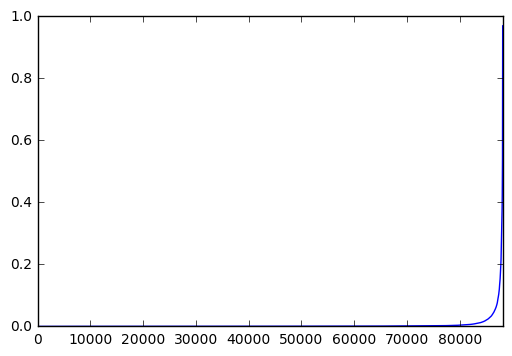

In [131]:
pd.Series(preds_bin).sort_values().reset_index(drop=True).plot()